## Loading data

pwd

In [2]:
%ll

total 2844
-rw-rw-r-- 1 1000     313 Oct 27  2018  codes.txt
drwxrwxr-x 2 1000   36864 Oct 27  2018  images/
drwxrwxr-x 2 1000   36864 Jun 14 10:40  labels/
-rw-r--r-- 1 root 2776939 Jun 24 22:17 'road segmentation.ipynb'
drwxr-xr-x 2 root    4096 Jun 14 10:43  test_images/
drwxr-xr-x 2 root    4096 Jun 14 10:41  test_labels/
drwxr-xr-x 2 root   20480 Jun 14 10:43  train_images/
drwxr-xr-x 2 root   20480 Jun 14 10:40  train_labels/
drwxr-xr-x 2 root    4096 Jun 14 10:43  valid_images/
drwxr-xr-x 2 root    4096 Jun 14 10:40  valid_labels/


In [3]:
%pwd
%ll
%cd ..
%ll

total 2844
-rw-rw-r-- 1 1000     313 Oct 27  2018  codes.txt
drwxrwxr-x 2 1000   36864 Oct 27  2018  images/
drwxrwxr-x 2 1000   36864 Jun 14 10:40  labels/
-rw-r--r-- 1 root 2776939 Jun 24 22:17 'road segmentation.ipynb'
drwxr-xr-x 2 root    4096 Jun 14 10:43  test_images/
drwxr-xr-x 2 root    4096 Jun 14 10:41  test_labels/
drwxr-xr-x 2 root   20480 Jun 14 10:43  train_images/
drwxr-xr-x 2 root   20480 Jun 14 10:40  train_labels/
drwxr-xr-x 2 root    4096 Jun 14 10:43  valid_images/
drwxr-xr-x 2 root    4096 Jun 14 10:40  valid_labels/
/home
total 612852
drwxrwxr-x 11 1000      4096 Oct 27  2018 1/
-rw-rw-rw-  1 root     21138 Jun 24 13:58 Digraph.gv
drwxrwxrwx  2 root      4096 Jun 17 17:32 __pycache__/
-rw-rw-rw-  1 root  13471919 Jun 17 21:02 best_model_weights.pth
drwxrwxr-x  1 1000      4096 Jun 24 22:17 camvid/
-rw-r--r--  1 root 598913237 Jun 14 10:34 camvid.tgz
-rw-r--r--  1 root      2170 Jun 14 10:40 dataset.py
-rw-r--r--  1 root       520 Jun 17 17:51 metrics.py
-rw-rw-rw-

In [4]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [5]:
DATA_DIR = 'camvid'

x_train_dir = os.path.join(DATA_DIR, 'train_images')
y_train_dir = os.path.join(DATA_DIR, 'train_labels')

x_valid_dir = os.path.join(DATA_DIR, 'valid_images')
y_valid_dir = os.path.join(DATA_DIR, 'valid_labels')

x_test_dir = os.path.join(DATA_DIR, 'test_images')
y_test_dir = os.path.join(DATA_DIR, 'test_labels')


In [6]:
# helper function for data visualization
def visualize(**images):

    n = len(images)
    plt.figure(figsize=(16, 5))  # 创建图像面板，设置宽度和高度
    for i, (name, image) in enumerate(images.items()):  # 遍历键值对
        plt.subplot(1, n, i + 1)  # 创建新的图像面板
        plt.xticks([])  # 设置x轴标签
        plt.yticks([])  # 设置y轴标签
        plt.title(' '.join(name.split('_')).title())  # 设置图像标题
        plt.imshow(image)  # 使用imshow()函数显示图像
    plt.show()  # 显示图像面板

In [7]:
import torch
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

In [7]:
class Dataset(BaseDataset):
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            augmentation=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        
        self.augmentation = augmentation

    
    def __getitem__(self, i):
                
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)
        
        # sky
        mask = (mask==17)
        mask = mask.astype('float')   
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        return image, mask.reshape(1,320,320)
        
    def __len__(self):
        return len(self.ids)

### Augmentations

In [8]:
import albumentations as albu

0 255


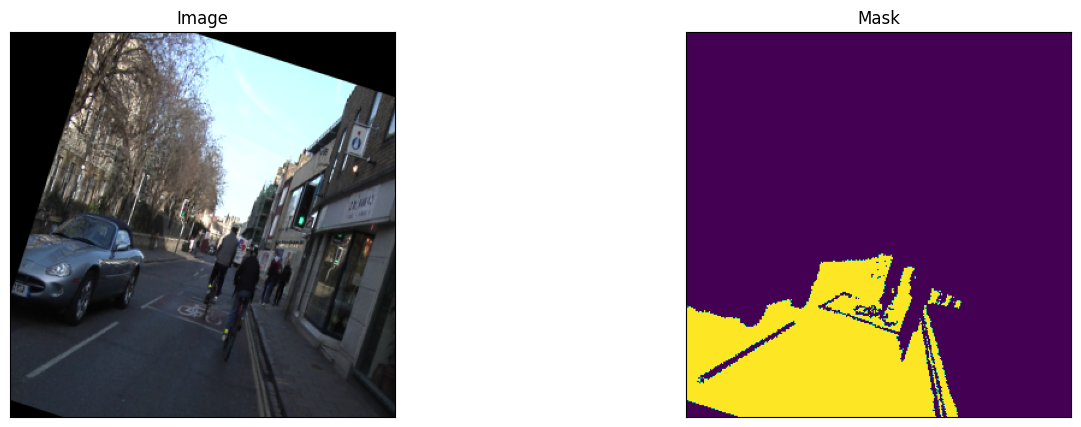

In [9]:
#### Visualize resulted augmented images and masks

def get_training_augmentation():
    train_transform = [
        albu.HorizontalFlip(p=0.5),
        albu.Resize(height=320, width=320, always_apply=True),
        albu.ShiftScaleRotate(scale_limit=0.1, rotate_limit=20, shift_limit=0.1, p=1, border_mode=0),
    ]
    return albu.Compose(train_transform)

def get_test_augmentation():
    train_transform = [
        albu.Resize(height=320, width=320, always_apply=True),
    ]
    return albu.Compose(train_transform)                                         

augmented_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    augmentation=get_training_augmentation(), 
)

# same image with different random transforms
for i in range(1):
    image, mask = augmented_dataset[1]
    print(np.min(image),np.max(image))
    visualize(image=image, mask=mask[0,:,:])

## Create model and train

In [10]:
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

In [11]:
#这段代码是一个基于U-Net的卷积神经网络模型，用于图像分割任务。其中包含了三个类：DoubleConv、Down和Up。
#DoubleConv类定义了一个双卷积层，包括两个卷积层、Batch Normalization和ReLU激活函数。
#Down类定义了一个下采样层，包括一个最大池化层和一个双卷积层。
#Up类定义了一个上采样层，包括一个上采样操作和一个双卷积层。
#其中，上采样操作可以选择使用双线性插值或转置卷积来实现。
#在forward函数中，输入x1和x2是两个特征图，x1经过上采样操作后与x2进行拼接，并进行双卷积操作。

In [12]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_channels // 2, in_channels // 2, kernel_size=2, stride=2)

        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = torch.tensor([x2.size()[2] - x1.size()[2]])
        diffX = torch.tensor([x2.size()[3] - x1.size()[3]])

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [13]:
#这是一个PyTorch实现的U-Net结构，通常用于图像分割任务。
#U-Net结构是一个完全卷积神经网络，由编码器路径和解码器路径组成，
#其中编码器和解码器之间有相应级别的跳跃连接。
#编码器路径用于捕获图像的上下文信息，而解码器路径用于恢复编码过程中丢失的空间信息。
#该结构包含下采样层（Down），用于降低特征图的空间维度，以及上采样层（Up），用于增加特征图的空间维度。
#DoubleConv模块由两个3x3卷积层和一个ReLU激活函数组成。
#OutConv模块是一个最终的卷积层，用于产生输出的logits，sigmoid函数应用于logits以获得最终输出。

In [14]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 32)
        self.down1 = Down(32, 64)
        self.down2 = Down(64, 128)
        self.down3 = Down(128, 256)
        self.down4 = Down(256, 256)
        self.up1 = Up(512, 128, bilinear)
        self.up2 = Up(256, 64, bilinear)
        self.up3 = Up(128, 32, bilinear)
        self.up4 = Up(64, 32, bilinear)
        self.outc = OutConv(32, n_classes)
        self.out  = torch.sigmoid
    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        logits = self.out(logits)
        return logits

In [24]:
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    augmentation=get_training_augmentation(), 
)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

In [25]:
net = UNet(n_channels=3, n_classes=1)

In [17]:
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
#from .unet_parts import *

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 32)
        self.down1 = Down(32, 64)
        self.down2 = Down(64, 128)
        self.down3 = Down(128, 256)
        self.down4 = Down(256, 256)
        self.up1 = Up(512, 128, bilinear)
        self.up2 = Up(256, 64, bilinear)
        self.up3 = Up(128, 32, bilinear)
        self.up4 = Up(64, 32, bilinear)
        self.outc = OutConv(32, n_classes)
        self.out  = torch.sigmoid
    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        logits = self.out(logits)
        return logits

if __name__ == '__main__':
    net = UNet(n_channels=3, n_classes=1)
    print(net)

UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(64, eps=1e-05, momentum=0.

In [26]:
import torch
import torch.nn as nn
from torchsummary import summary
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter()
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_channels // 2, in_channels // 2, kernel_size=2, stride=2)

        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = torch.tensor([x2.size()[2] - x1.size()[2]])
        diffX = torch.tensor([x2.size()[3] - x1.size()[3]])

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])

        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)



class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 32)
        self.down1 = Down(32, 64)
        self.down2 = Down(64, 128)
        self.down3 = Down(128, 256)
        self.down4 = Down(256, 256)
        self.up1 = Up(512, 128, bilinear)
        self.up2 = Up(256, 64, bilinear)
        self.up3 = Up(128, 32, bilinear)
        self.up4 = Up(64, 32, bilinear)
        self.outc = OutConv(32, n_classes)
        self.out  = torch.sigmoid
    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        logits = self.out(logits)
        return logits

# 可视化模型结构
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet(n_channels=3, n_classes=1).to(device)
#summary(model, input_size=(3, 320, 320))
summary(model, (3, 320, 320))
writer.add_graph(model, torch.zeros(1, 3, 320, 320).to(device))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 320, 320]             896
       BatchNorm2d-2         [-1, 32, 320, 320]              64
              ReLU-3         [-1, 32, 320, 320]               0
            Conv2d-4         [-1, 32, 320, 320]           9,248
       BatchNorm2d-5         [-1, 32, 320, 320]              64
              ReLU-6         [-1, 32, 320, 320]               0
        DoubleConv-7         [-1, 32, 320, 320]               0
         MaxPool2d-8         [-1, 32, 160, 160]               0
            Conv2d-9         [-1, 64, 160, 160]          18,496
      BatchNorm2d-10         [-1, 64, 160, 160]             128
             ReLU-11         [-1, 64, 160, 160]               0
           Conv2d-12         [-1, 64, 160, 160]          36,928
      BatchNorm2d-13         [-1, 64, 160, 160]             128
             ReLU-14         [-1, 64, 1

/tmp/ipykernel_195/1951659829.py:57: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  diffY = torch.tensor([x2.size()[2] - x1.size()[2]])
/tmp/ipykernel_195/1951659829.py:57: TracerWarning: Converting a tensor to a Python index might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  diffY = torch.tensor([x2.size()[2] - x1.size()[2]])
/tmp/ipykernel_195/1951659829.py:58: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time

torch.Size([3, 320, 320])
(1, 320, 320)
0.0 1.0


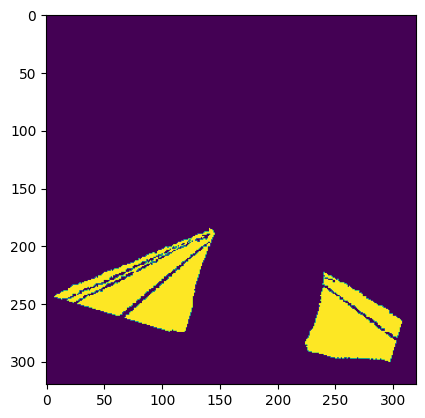

torch.Size([1, 1, 320, 320])
0.033969328 0.9974847


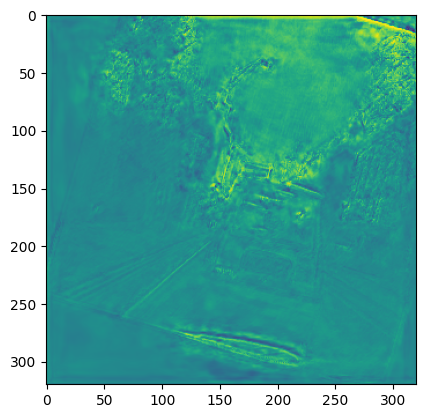

In [68]:
image, mask = train_dataset[1]  # 从训练数据集中获取图像和掩码数据

with torch.no_grad():  # 在评估阶段，不需要计算梯度
    net.to('cuda')  # 将网络模型移到GPU上进行加速计算
    image = image/255.  # 对图像进行归一化，将像素值缩放到0-1范围
    image = image.astype('float32')  # 将图像的数据类型转换为float32
    image = torch.from_numpy(image)  # 将numpy数组转换为PyTorch张量
    image = image.permute(2,0,1)  # 重排图像通道的顺序，将通道维度放在最前面
    image = image.to()  # 将图像数据移到GPU上进行加速计算
    print(image.shape)  # 打印图像张量的形状信息
    
    #pred = torch.argmax(pred, dim=1).squeeze().numpy()
    pred = net(image.unsqueeze(0).cuda())  # 将图像输入网络进行预测，并将结果移到GPU上进行加速计算
    pred = pred.cpu()  # 将预测结果移到CPU上进行后续处理

plt.figure('mask')  # 创建名为'mask'的图像窗口
print(mask.shape)  # 打印掩码张量的形状信息
print(np.min(mask),np.max(mask))  # 打印掩码张量的最小值和最大值
plt.imshow(mask[0,:,:])  # 在图像窗口中显示掩码图像
plt.show()  # 显示图像窗口

plt.figure('pred')  # 创建名为'pred'的图像窗口
# pred = pred.view(720,960)
print(pred.shape)  # 打印预测结果张量的形状信息
print(np.min(pred.numpy()),np.max(pred.numpy()))  # 打印预测结果张量的最小值和最大值
plt.imshow(pred[0,0,:,:])  # 在图像窗口中显示预测结果图像
plt.show()  # 显示图像窗口

In [79]:
import matplotlib.pyplot as plt
from torch.autograd import Variable
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc

net.cuda()
optimizer = optim.RMSprop(net.parameters(), lr=0.003, weight_decay=1e-8)
criterion = nn.BCELoss()
# 创建空列表
loss_list = []
acc_list = []
prec_list = []
rec_list = []
f1_list = []
roc_auc_list = []

device = 'cuda'
for epoch in range(300):
    
    net.train()
    epoch_loss = 0
    
    y_true = []
    y_pred = []
    
    for data in train_loader:
        
        images,labels = data
        images = images.permute(0,3,1,2)
        images = images/255.
        images = Variable(images.to(device=device, dtype=torch.float32))
        labels = Variable(labels.to(device=device, dtype=torch.float32))
        
        pred = net(images)
        
        loss = criterion(pred, labels)
        epoch_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        pred_labels = (pred > 0.5).float()
        y_true.extend(labels.cpu().numpy().ravel().tolist())
        y_pred.extend(pred_labels.cpu().detach().numpy().ravel().tolist())
        
        loss_list.append(epoch_loss)
        print(f"Epoch {epoch+1}: Loss: {epoch_loss:.4f}, Acc: {acc:.4f},  Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}, ROC AUC: {roc_auc:.4f}")
    epoch_loss /= len(train_loader)
    loss_list.append(epoch_loss)
    
    acc = accuracy_score(y_true, y_pred)
    acc_list.append(acc)
    
    prec = precision_score(y_true, y_pred)
    prec_list.append(prec)
    
    rec = recall_score(y_true, y_pred)
    rec_list.append(rec)
    
    f1 = f1_score(y_true, y_pred)
    f1_list.append(f1)
    
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    roc_auc_list.append(roc_auc)
    
# 保存模型的权重
torch.save(net.state_dict(), 'best_model_weights.pth')
# 绘制损失函数曲线
plt.plot(loss_list)
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# 绘制准确率曲线
plt.plot(acc_list)
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

# 绘制精确度曲线
plt.plot(prec_list)
plt.title('Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.show()

# 绘制召回率曲线
plt.plot(rec_list)
plt.title('Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.show()

# 绘制F1分数曲线
plt.plot(f1_list)
plt.title('F1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.show()

# 绘制ROC曲线
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

SyntaxError: EOL while scanning string literal (4185698528.py, line 47)

## Test model

In [26]:
test_dataset_noaug = Dataset(
    x_train_dir, 
    y_train_dir,
    augmentation=get_test_augmentation(),
    )

torch.Size([3, 320, 320])


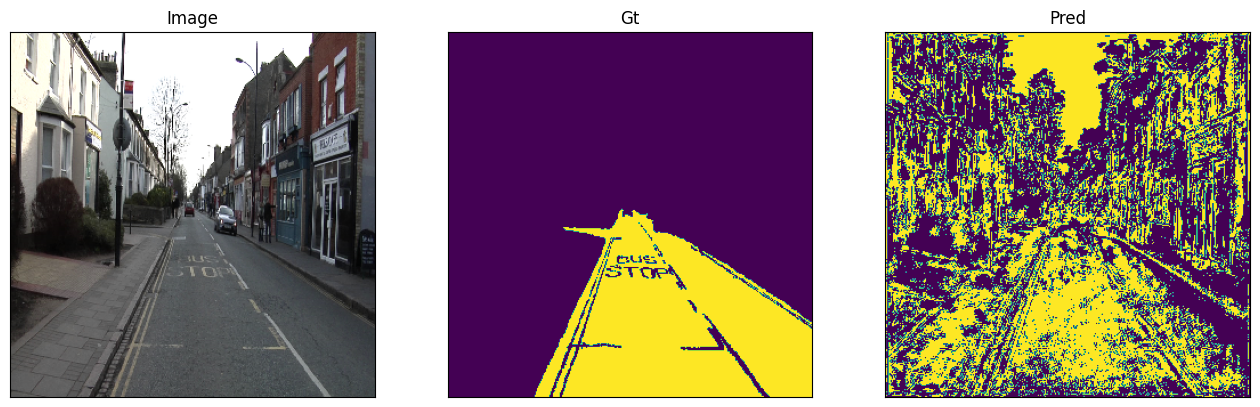

(1, 320, 320)
0.0 1.0


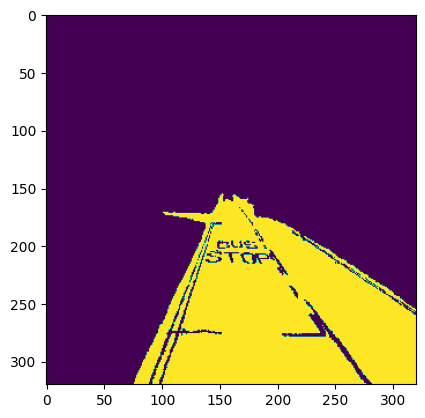

False True


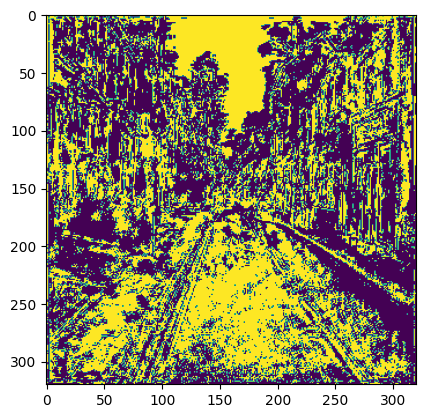

In [30]:
net.cuda()
image, mask = test_dataset_noaug[120]

show_image = image
with torch.no_grad():
    image = image/255.
    image = image.astype('float32')
    image = torch.from_numpy(image)
    image = image.permute(2,0,1)
    image = image.to()
    print(image.shape)
    
    pred = net(image.unsqueeze(0).cuda())
    pred = pred.cpu()
    
pred = pred>0.5
visualize(image=show_image,GT=mask[0,:,:],Pred=pred[0,0,:,:])
    
plt.figure('mask')
print(mask.shape)
print(np.min(mask),np.max(mask))
plt.imshow(mask[0,:,:])
plt.show()

#plt.figure('pred')
#pred = pred.view(720,960)
#print(pred.shape)

pred = pred>0.8
print(np.min(pred.numpy()),np.max(pred.numpy()))
plt.imshow(pred[0,0,:,:])
plt.show()

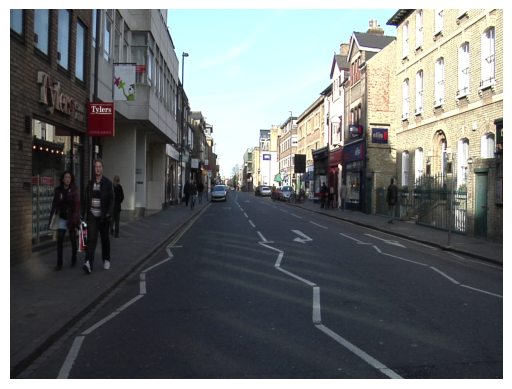

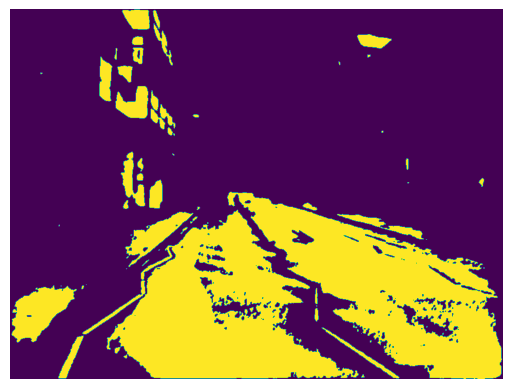

In [35]:
import cv2
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Load the pre-trained model
net = UNet(n_channels=3, n_classes=1)
net.load_state_dict(torch.load('test_best_model_weights.pth'))

# Load the test image
image = Image.open('test.png')

# Preprocess the image
image = np.array(image)
image = image / 255.
image = image.astype('float32')
image = torch.from_numpy(image)
image = image.permute(2, 0, 1)
image = image.unsqueeze(0)

# Make a prediction on the preprocessed image using the loaded model
with torch.no_grad():
    pred = net(image)

# Threshold the predicted output at 0.5
pred = pred > 0.5

# Visualize the original image and predicted mask
plt.figure('Original Image')
plt.imshow(image.squeeze().permute(1, 2, 0).numpy())
plt.axis('off')

plt.figure('Predicted Mask')
plt.imshow(pred.squeeze().cpu().numpy())
plt.axis('off')

# Save the predicted mask as a JPEG image
pred_image = (pred.squeeze().cpu().numpy() * 255).astype(np.uint8)
cv2.imwrite('predicted_mask.jpg', pred_image)

plt.show()


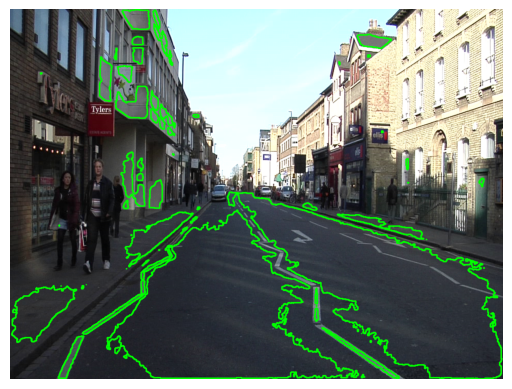

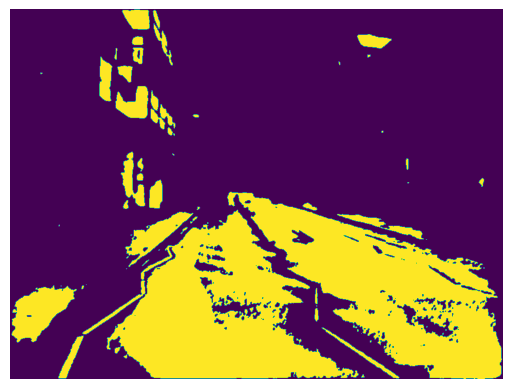

In [36]:
import cv2
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# 导入预训练模型
net = UNet(n_channels=3, n_classes=1)
net.load_state_dict(torch.load('test_best_model_weights.pth'))

# 加载测试图像
image = Image.open('test.png')

# 预处理图像
image = np.array(image)
image = image / 255.
image = image.astype('float32')
image = torch.from_numpy(image)
image = image.permute(2, 0, 1)
image = image.unsqueeze(0)

# 使用加载的模型对预处理图像进行预测
with torch.no_grad():
    pred = net(image)

# 将预测输出阈值化为0.5
pred = pred > 0.5

# 将预测的掩膜转换为numpy数组
pred_np = pred.squeeze().cpu().numpy()

# 找到预测掩膜的轮廓
contours, _ = cv2.findContours(pred_np.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

# 在原始图像上绘制轮廓
image_contours = cv2.drawContours(np.array(image.squeeze().permute(1, 2, 0) * 255, dtype=np.uint8), contours, -1, (0, 255, 0), 2)

# Visualize the original image with contours and predicted mask
plt.figure('Original Image with Contours')
plt.imshow(image_contours)
plt.axis('off')

plt.figure('Predicted Mask')
plt.imshow(pred_np)
plt.axis('off')

# Save the predicted mask as a JPEG image
pred_image = (pred_np * 255).astype(np.uint8)
cv2.imwrite('predicted_mask.jpg', pred_image)

plt.show()